In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path
classLabels = ["exotic", "cozy", "luxurious", "nature_freindly", "modern" ]

print(torch.__version__)

2.3.0+cpu


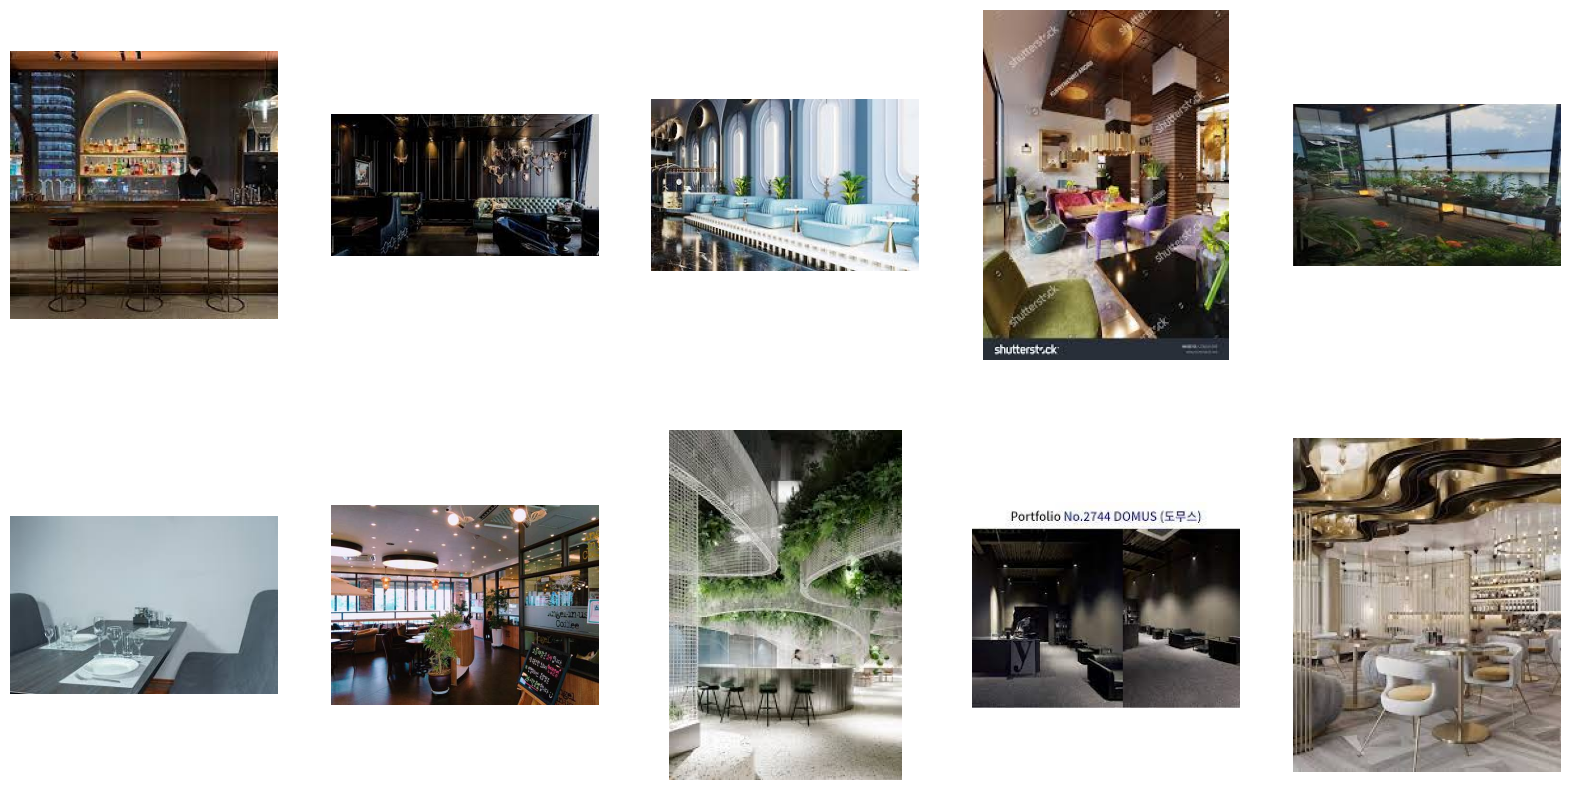

In [2]:
import os
import random

image_folder_path = 'original'

# 폴더 내의 모든 파일 목록을 가져옵니다.
image_files = [os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]

# 랜덤하게 10개의 이미지를 선택합니다. (이미지 수가 10개 미만일 경우 모든 이미지를 선택)
selected_images = random.sample(image_files, min(10, len(image_files)))

# 선택된 이미지를 출력합니다.
plt.figure(figsize=(20, 10))  # 출력될 이미지 크기를 설정합니다.
for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    plt.subplot(2, 5, i + 1)  # 2행 5열의 그리드에서 이미지를 출력합니다.
    plt.imshow(img)
    plt.axis('off')  # 축을 보이지 않게 합니다.
plt.show()

In [3]:
df = pd.DataFrame({"image": sorted([int(x.name.strip(".jpg")) for x in Path("original").iterdir()])})
df["image"] = df["image"].astype(str) + ".jpg"

df.to_csv("data.csv", index=False)
# 데이터프레임의 처음 10개 및 마지막 10개 행 출력
print(df.head(10))
print(df.tail(10))

    image
0   1.jpg
1   2.jpg
2   3.jpg
3   4.jpg
4   5.jpg
5   6.jpg
6   7.jpg
7   8.jpg
8   9.jpg
9  10.jpg
       image
365  366.jpg
366  367.jpg
367  368.jpg
368  369.jpg
369  370.jpg
370  371.jpg
371  372.jpg
372  373.jpg
373  374.jpg
374  375.jpg


52.jpg


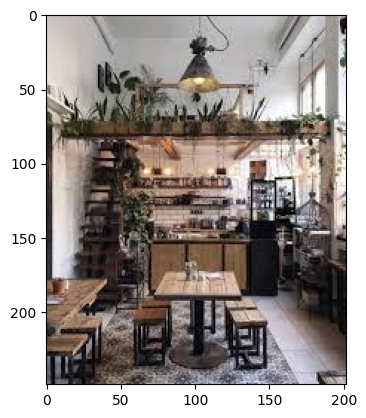

In [4]:
def visualizeImage(idx):
    fd = df.iloc[idx]
    image = fd['image']
    label = fd[1:].to_numpy()
    print(image)
    image = Image.open("original/" + image)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    classes = np.array(classLabels)[label.astype(np.bool_)]  # np.bool 대신 np.bool_ 사용
    for i, s in enumerate(classes):
        ax.text(0, i * 20, s, verticalalignment='top', color="white", fontsize=16, weight='bold')
    plt.show()

visualizeImage(51)

In [5]:
#데이터 피딩을 위한 작업

class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None ):

    self.df = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transforms = transforms

  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    image = Image.open(self.img_dir/d.image).convert("RGB")
    label = torch.tensor(d[1:].tolist() , dtype=torch.float32)

    if self.transforms is not None:
      image = self.transforms(image)
    return image,label

  def __len__(self):
    return len(self.df)

In [6]:
transform = transforms.Compose([
                               transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

# 데이터셋을 초기화할 때 파일 경로를 지정합니다.
dataset = MyDataset("data.csv" , Path("original") , transform)

# DataLoader를 사용하여 데이터를 불러옵니다.
dataloader = DataLoader(dataset, shuffle=True, batch_size=675)
print(f"valset len {len(dataset)}")


valset len 375


In [7]:
# resnet50모델로 전이학습 하겠습니다.

model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)

c:\Users\djdj4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\djdj4\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048


In [8]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
top_head = create_head(num_features , len(classLabels)) # because ten classes
top_head = top_head.to(device)
model.fc = top_head # replace the fully connected layer

cpu


In [9]:
# 모델의 바닥 일부를 freezing합니다.
# 'conv1', 'bn1', 'relu', 'maxpool', 'layer1'을 포함한 초기 레이어를 freeze

for name, child in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        break  # 'layer1' 다음 레이어에 도달하면 loop 종료


In [10]:
#loss 함수와 옵티마이져, 스케줄로를 정의
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [11]:
#모델 로드 및 추론용으로 세팅
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)
/content/LatestCheckpoint.pt
'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.0009999999999999983
    maximize: False
    weight_decay: 0
)

In [12]:
def labels(output, classLabels):
    predicted_labels = [classLabels[j] for j, pred in enumerate(output[0]) if pred]
    return predicted_labels

In [13]:
def predict_cafe_list(model, image_path, device):
    # Define image transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size expected by the model
        transforms.ToTensor(),           # Convert PIL Image to tensor
        transforms.Normalize(            # Normalize with ImageNet mean and standard deviation
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        output = model(image)  # Forward pass
        output = torch.sigmoid(output)  # Apply sigmoid activation for binary classification
        output = output > 0.2  # Apply thresholding
    for i in range(len(output)):
        predicted_labels = [classLabels[j] for j, pred in enumerate(output[i]) if pred]

    return predicted_labels

In [14]:
image_path = r"original/360.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
result = predict_cafe_list(model, image_path, device)
print("추론 결과:")
print(result)

추론 결과:
['exotic', 'cozy', 'luxurious']


전경 분류

In [16]:
import keras
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [17]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

In [18]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model1 = Model(conv_base.input, predictions)

In [19]:
optimizer = keras.optimizers.Adam()
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

전경 모델 불러오는 파트

In [20]:
import warnings

try:
    # architecture and weights from HDF5
    model1 = load_model('model.h5')
except Exception as e:
    warnings.warn(f"에러 HDF5: {e}")
try:
    # architecture from JSON, weights from HDF5
    with open('architecture.json') as f:
        model1 = model_from_json(f.read())
    model1.load_weights('weights.h5')
except Exception as e:
    warnings.warn(f"HDF5 에러: {e}")

C:\Users\djdj4\AppData\Local\Temp\ipykernel_16404\1436308106.py:14: UserWarning: HDF5 에러: Could not locate class 'Functional'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, None, None, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'ZeroPadding2D', 'config': {'name': 'conv1_pad', 'trainable': False, 'dtype': 'float32', 'padding': [[3, 3], [3, 3]], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, None, None, 3]}, 'name': 'conv1_pad', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv1_conv', 't

In [21]:
# architecture and weights from HDF5
#model1 = load_model('model.h5')

# architecture from JSON, weights from HDF5
#with open('architecture.json') as f:
    #model1 = model_from_json(f.read())
#model1.load_weights('weights.h5')

함수

In [22]:
def predict_cafe(image_path, model1):
    # 이미지 로드 및 전처리
    img = Image.open(image_path).resize((224, 224))
    img_array = preprocess_input(np.array(img)[np.newaxis, :])

    # 모델 예측
    pred_probs = model1.predict(img_array)

    # 예측 결과 해석 파트
    predicted_label = "Cafe" if pred_probs[0][0] > 0.8 else "Non-Cafe"

    #카페인지 아닌지
    return predicted_label

In [23]:
#이미지 경로 -> 미리 지정해놓고 사용
image_path = "data/validation/Cafe/21.jpg"

# 함수 호출
predicted_Cafe = predict_cafe(image_path, model1)
print("Predicted Cafe:", predicted_Cafe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Cafe: Cafe


In [25]:
import requests
import csv
import urllib.request
from urllib.error import HTTPError
import os
from typing import List
from fastapi import HTTPException

classLabels = ["exotic", "cozy", "luxurious", "nature_freindly", "modern"]
label_mapping = {
    "exotic": "이국적인",
    "cozy": "포근",
    "luxurious": "고급스러운",
    "nature_freindly": "자연친화",
    "modern": "현대"
}

def find_available_image_path(path, cafeNum):
    image_num = 1
    while True:
        img_path = os.path.join(path, f"cafeImg/{cafeNum}_{image_num}.jpg")
        if not os.path.exists(img_path):
            return img_path
        image_num += 1

def translate_label(labels):
    translated_labels = []
    for label in labels:
        if label in label_mapping:
            translated_labels.append(label_mapping[label])
        else:
            translated_labels.append(label)
    return translated_labels

def cafe_tag_save():
    csv_file_path = r'C:\Users\djdj4\vscode\capstone\크롤링, API\naver_cafe3.csv'
    path = r"C:\Users\djdj4\vscode\capstone\cafeImg\\"

    with open(csv_file_path, mode='r', encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            cafeNum = row['카페 번호']
            url = f'http://localhost:8080/get_cafe_images/?cafe_number={cafeNum}'  # FastAPI 서버 URL

            # 요청 보내기
            response = requests.get(url)

            # 응답 확인
            if response.status_code == 200:
                images_data = response.json()  # JSON 형식의 응답을 파싱
                all_tags = []  # 모든 이미지에 대한 태그를 모을 리스트

                for image_info in images_data:
                    image_number = image_info.get('number')
                    image_url = image_info.get('img')

                    img_path = path + str(cafeNum) + '_' + str(image_number) + '.jpg'    # 이미지 경로 생성
                    try:
                        urllib.request.urlretrieve(image_url, img_path)                    # 이미지 다운로드
                    except HTTPError as e:
                        if e.code == 404:
                            print(f"HTTP Error 404: {image_url}를 찾을 수 없습니다. 다음 이미지로 넘어갑니다.")
                            continue
                        else:
                            raise e
                    
                    #카페 전경 확인
                    predicted_Cafe = predict_cafe(img_path, model1)

                    if predicted_Cafe == 'Cafe':
                        English_labels = predict_cafe_list(model, img_path, device)   #이미지 -> 형용사

                        tag_list = translate_label(English_labels)
                        all_tags.extend(tag_list)  # 태그를 모든 이미지에 대한 리스트에 추가

                        print(f"카페 번호 {cafeNum}의 형용사는: {tag_list}")

                    elif predicted_Cafe == 'Non-Cafe':
                        print(f"{img_path} 전경이 아닙니다.")
                        continue
                    else:
                        break

                unique_tags = list(set(all_tags))  # 중복 제거를 위해 set으로 변환 후 다시 리스트로 변환

                url_2 = f'http://localhost:8080/cafe/tags/{cafeNum}'    # FastAPI 서버 URL

                # 응답 확인
                if response.status_code == 200:
                    print(f"카페 번호 {cafeNum}의 형용사가 성공적으로 서버에 전송되었습니다.")
                else:
                    print(f"서버에 카페 번호 {cafeNum}의 형용사가 전송하는데 실패했습니다. 응답 코드: {response.status_code}")

                # 중복이 제거된 유일한 값들만을 가지는 리스트를 JSON으로 직렬화하여 요청 보내기
                response = requests.post(url_2, json=unique_tags)
            else:
                print(f"카페 {cafeNum}의 이미지들을 가져오는 것을 실패했습니다. 응답 코드: {response.status_code}")

cafe_tag_save()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '포근', '고급스러운']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '자연친화']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '포근']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '현대']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '포근', '현대']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '현대']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '포근']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '포근']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
카페 번호 1256278263.0의 형용사는: ['이국적인', '포근']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
카페 번호 1256278263.0의 형용사는: ['포근', '고급스러운']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/s